In [2]:
def normalizeMe(myGalaxy):
    df0=pd.DataFrame({'Me' : myGalaxy.groupby( ['alpha', "DEC", "RA"])['Me'].sum()}).reset_index()
    # Calculate number of datapoints for normalization along distance
    dfcount=pd.DataFrame({'Me' : myGalaxy.groupby( ['alpha'])['Me'].count()}).reset_index()
    # Correct Luminosity
    dfcount=dfcount.set_index(["alpha"])
    df0=df0.set_index(["alpha", "DEC", "RA"],)
    df0=df0/dfcount
    df0.reset_index(inplace=True) 
    # accommodate increasing surface covered by the data
    # the reason for adjusting dfcount here is because the aggregation of mass pays not attention to the increasing volume
    # thus the normalization above should be done before we adjust dfcount to get obs/UnitOfVolume
    return df0, dfcount

#submit a job, which inserts the query results into a table in the MyDB database context. 
#Wait until the job is done and get its status.






querydeltapetromagbinned="select s.z, , ROUND(petroR50_z, 2) AS petroR50_z, ROUND(petroRad_z, 2) AS petroRad_z \
            into mydb.HU_SpectOpt from SpecObj s,PhotoObj p \
            where programname \
            in ('legacy', 'boss') and class='GALAXY' and (petroMagErr_z/petroMag_z) between 0 and 0.01 \
            and p.SpecObjID=s.specObjID"

querydeltapetromagcounted="select s.z, \
            ROUND(petroR50_z, 2) AS petroR50_z \
            , COUNT(1) AS n_petroR50_z \
            -- Change all 'R50' to 'Rad', above, for that data. \
            into mydb.HU_SpectOpt from SpecObj s,PhotoObj p \
            where programname \
            in ('legacy', 'boss') and class='GALAXY' and (petroMagErr_z/petroMag_z) between 0 and 0.01 \
            and p.SpecObjID=s.specObjID \
            GROUP BY ROUND(petroR50_z, 2) -- Change 'R50' to 'Rad' for that data."


querypop="SELECT ROUND(z, 2) AS zQSOtarget -- bin redshift (Δz = 0.01) \
            , COUNT(1) AS nQSOtarget -- bin population \
            FROM SpecObj s \
            WHERE programname IN ('legacy', 'boss') -- redundant for local DB \
            AND sourceType = 'QSO' AND z >= 0.005 -- Remove z = 0 data. \
            GROUP BY ROUND(z, 2) -- This line bins the data.  \
            ORDER BY 1"

queryQSO="SELECT ROUND(Redshift, 2) AS z -- bin redshift (Δz = 0.01) \
            , COUNT(1) AS n -- bin population \
            FROM NEDagn \
            WHERE Redshift >= 0.005 -- Remove z = 0 data. \
            GROUP BY ROUND(Redshift, 2) -- This line bins the data."


query1="SELECT s.z -- ROUND(arg, 3), below, expresses measurements in milliarcseconds \
            , ROUND((petroR50_g + petroR50_r + petroR50_i) / 3 , 3) AS AVGpetroR50_gri \
            , ROUND((petroRad_g + petroRad_r + petroRad_i) / 3 / 2.23 , 3) AS 'AVGpetroRad_griDIV2.23' \
            ROUND( -- SELECT for average dataset error \
            (AVG(petroR50Err_g/petroR50_g) + AVG(petroR50Err_r/petroR50_r) + \
            AVG(petroR50Err_i/petroR50_i)) / 3 * 100, 1) AS AVGR50ErrorPct \
            , ROUND(AVG(s.zErr/s.z * 100), 2) AS AVGzErrPct \
            FROM SpecObj s, PhotoObj p \
            WHERE programname IN ('legacy', 'boss') -- redundant for local DB \
            AND class = 'GALAXY' \
            -- >=0 disallows -1000 and -9999 ("not calculated" codes) \
            AND petroR50_g BETWEEN 0 AND 50 \
            AND petroR50Err_g >= 0 \
            AND petroR50_r BETWEEN 0 AND 50 \
            AND petroR50Err_r >= 0 \
            AND petroR50_i BETWEEN 0 AND 50 \
            AND petroR50Err_i >= 0 \
           -- max. measurement error is 20% \
            AND petroR50Err_g / petroR50_g < 0.20 \
            AND petroR50Err_r / petroR50_r < 0.20 \
            AND petroR50Err_i / petroR50_i < 0.20 \
            -- join tables on s.specObjID key \
            AND p.specObjID = s.specObjID \
            AND s.z > 0 -- zErr/z query requirement
            "




ROUND(petroR50_z, 2) AS petroR50_z
, COUNT(1) AS n_petroR50_z
-- Change all 'R50' to 'Rad', above, for that data.


SQL query yielding the datasets on slides 63 & 64
Graphed results reflect a prepared local database that excludes low-quality data;
running this query on the SDSS CAS will generate similar but different results.
SELECT
s.z -- identical to z_noqso for BOSS data
, ROUND(petroR50_z, 2) AS petroR50_z
, ROUND(petroRad_z, 2) AS petroRad_z
FROM
SpecObj s
, PhotoObj p
WHERE
 programname IN ('legacy', 'boss')
AND class = 'GALAXY'
AND (petroMagErr_z / petroMag_z) BETWEEN 0 AND 0.01
AND p.specObjID = s.specObjID




jobId = CasJobs.submitJob(sql=CasJobs_TestQuery, context="MyDB")
jobDescription = CasJobs.waitForJob(jobId=jobId, verbose=False)
print(jobId)
print(jobDescription)

select top 10 s.bestObjID, s.ra, s.dec, s.fluxObjID,
  s.z,  s.zErr, 
  p.fiber2Mag_z, p.fiber2MagErr_z,
  p.petroMag_z,  p.petroMagErr_z,
  p.petroR50_z, p.petroR50Err_z, 
  p.petroR50_g,  p.petroR50Err_g,
  p.petroR50_r, p.petroR50Err_r,
  p.petroR50_i, p.petroR50Err_i,
  
  p.petroRad_g,  p.petroRadErr_g,
  p.petroRad_r, p.petroRadErr_r,
  p.petroRad_i, p.petroRadErr_i,
  p.petroRad_z, p.petroRadErr_z,
  s.z_noqso, s.zErr_noqso 
from SpecObj as s join PhotoObj as p
   on s.bestObjID =p.objID  
where 
  class='GALAXY' 
  and p.mode = 1 and p.clean = 1 and s.programname IN ('legacy', 'boss') 
     and s.zErr >= 0 AND s.zErr_noqso > 0 and s.z > 0 and s.z_noqso>0  
     and ABS(s.zErr/s.z) <= 0.01 AND ABS(s.zErr_noqso/s.z_noqso) <= 0.01
     and p.fiberMag_g <> -9999 AND p.fiberMag_g <> -9999 AND p.fiberMag_r <> -9999  AND p.fiberMag_i <> -9999 AND p.fiberMag_z <> -9999



query1="SELECT s.z \
            , ROUND((petroR50_g + petroR50_r + petroR50_i) / 3 , 3) AS AVGpetroR50_gri \
            , ROUND((petroRad_g + petroRad_r + petroRad_i) / 3 / 2.23 , 3) AS AVGpetroRad_griDIV2.23 \
            , ROUND( (AVG(petroR50Err_g/petroR50_g) + AVG(petroR50Err_r/petroR50_r) + AVG(petroR50Err_i/petroR50_i)) / 3 * 100, 1) AS AVGR50ErrorPct \
            , ROUND(AVG(s.zErr/s.z * 100), 2) AS AVGzErrPct \
            FROM mydb.MyTable \
            AND petroR50_g BETWEEN 0 AND 50 \
            AND petroR50Err_g >= 0 \
            AND petroR50_r BETWEEN 0 AND 50 \
            AND petroR50Err_r >= 0 \
            AND petroR50_i BETWEEN 0 AND 50 \
            AND petroR50Err_i >= 0 \
            AND petroR50Err_g / petroR50_g < 0.20 \
            AND petroR50Err_r / petroR50_r < 0.20 \
            AND petroR50Err_i / petroR50_i < 0.20 "

df = CasJobs.executeQuery(sql=query1, context="MyDB", format="pandas")


#execute a quick SQL query:
df["NZ"]=[100**((x)/5) for x in df.petroMag_z]
df.plot.scatter(x="alpha", y="fiber2Mag_z")

querydeltaz="select dec as 'DEC', ra as 'RA', z as 'Z', fiber2Mag_z, petroMag_z from mydb.MyTable \
            where (fiber2MagErr_z/fiber2Mag_z) between 0 and 0.01"

df = CasJobs.executeQuery(sql=querydeltaz, context="MyDB", format="pandas")

# old

select s.bestObjID, s.ra as RA, s.dec as DEC, s.fluxObjID,
  s.z as Z,  s.zErr, 
  p.fiber2Mag_z, p.fiber2MagErr_z,
  p.petroMag_z,  p.petroMagErr_z,
  p.petroR50_z, p.petroR50Err_z, 
  p.petroR50_g,  p.petroR50Err_g,
  p.petroR50_r, p.petroR50Err_r,
  p.petroR50_i, p.petroR50Err_i,
  
  p.petroRad_g,  p.petroRadErr_g,
  p.petroRad_r, p.petroRadErr_r,
  p.petroRad_i, p.petroRadErr_i,
  p.petroRad_z, p.petroRadErr_z,
  ROUND((petroR50_g + petroR50_r + petroR50_i) / 3 , 3) AS AVGpetroR50_gri ,
  ROUND((petroRad_g + petroRad_r + petroRad_i) / 3 / 2.23 , 3) AS AVGpetroRad_griDIV2 ,
  ROUND( ((petroR50Err_g/petroR50_g) + (petroR50Err_r/petroR50_r) + (petroR50Err_i/petroR50_i)) / 3 * 100, 1) AS AVGR50ErrorPct,
  ROUND((s.zErr/s.z * 100), 2) AS AVGzErrPct,
  s.z_noqso, s.zErr_noqso into mydb.boss from SpecObj as s join PhotoObj as p
   on s.bestObjID =p.objID  
where 
  class='GALAXY' 
  and p.mode = 1 and p.clean = 1 and s.programname IN ('boss') 
  and s.zErr >= 0 AND s.z > 0 and ABS(s.zErr/s.z) <= 0.02 
  and p.fiberMag_g <> -9999 AND p.fiberMag_r <> -9999  
  AND p.fiberMag_i <> -9999 AND p.fiberMag_z <> -9999
  and p.petroR50_g <> -9999 AND p.petroR50_r <> -9999  
  AND p.petroR50_i <> -9999 AND p.petroR50_z <> -9999
  and p.petroRad_g <> -9999 AND p.petroRad_r <> -9999  
  AND p.petroRad_i <> -9999 AND p.petroRad_z <> -9999
  
# new  
  
select s.bestObjID, s.ra as RA, s.dec as DEC, s.fluxObjID,
  s.z as Z,  s.zErr, 
  p.fiber2Mag_z, p.fiber2MagErr_z,
  p.petroMag_z,  p.petroMagErr_z,
  p.petroR50_z, p.petroR50Err_z, 
  p.petroR50_g,  p.petroR50Err_g,
  p.petroR50_r, p.petroR50Err_r,
  p.petroR50_i, p.petroR50Err_i,
  
  p.petroRad_g,  p.petroRadErr_g,
  p.petroRad_r, p.petroRadErr_r,
  p.petroRad_i, p.petroRadErr_i,
  p.petroRad_z, p.petroRadErr_z,
  ROUND((petroR50_g + petroR50_r + petroR50_i) / 3 , 3) AS AVGpetroR50_gri ,
  ROUND((petroRad_g + petroRad_r + petroRad_i) / 3 / 2.23 , 3) AS AVGpetroRad_griDIV2 ,
  ROUND( ((petroR50Err_g/petroR50_g) + (petroR50Err_r/petroR50_r) + (petroR50Err_i/petroR50_i)) / 3 * 100, 1) AS AVGR50ErrorPct,
  ROUND((s.zErr/s.z * 100), 2) AS AVGzErrPct,
  s.z_noqso, s.zErr_noqso into mydb.boss from SpecObj as s join PhotoObj as p
   on s.bestObjID =p.objID  
where 
  class='GALAXY' 
  and p.mode = 1 and p.clean = 1 and s.programname IN ('legacy') 
  and s.zErr >= 0 AND s.z > 0 and ABS(s.zErr/s.z) <= 0.02 
  
  and p.fiberMag_g <> -9999 AND p.fiberMag_r <> -9999  
  AND p.fiberMag_i <> -9999 AND p.fiberMag_z <> -9999
  
  and p.petroR50_g <> -9999 AND p.petroR50_r <> -9999  
  AND p.petroR50_i <> -9999 AND p.petroR50_z <> -9999
  
  and p.petroRad_g <> -9999 AND p.petroRad_r <> -9999  
  AND p.petroRad_i <> -9999 AND p.petroRad_z <> -9999
  
  
     

In [1]:
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import os;
import parameters;
import pandas as pd;
import sys;
import json;
from io import StringIO
from io import BytesIO
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import HULib

import glue
import seaborn as sns
parameters.glueme = True  # load data to glue for manipulation of the Universe

# # Define login Name and password before running these examples
# Authentication_loginName = 'ny2292000';
# Authentication_loginPassword = 'wy7PGC9kdRGLCnP'

# #logging in and getting current token from different ways
# token1 = Authentication.login(Authentication_loginName, Authentication_loginPassword);
# #getting curent user info

# user = Authentication.getKeystoneUserWithToken(token1)
# print("userName=" + user.userName)
# print("id=" + user.id)
# iden = Authentication.identArgIdentifier()
# print("ident="+iden)

df_boss = pd.read_csv("./boss_ny2292000.csv")
df_legacy = pd.read_csv("./legacy_ny2292000.csv")
df_boss=df_boss[df_boss.petroR50_i!=-9999]
df_boss=df_boss[df_boss.petroR50_r!=-9999]
df_boss=df_boss[df_boss.petroR50_g!=-9999]
df_boss=df_boss[df_boss.petroR50_z!=-9999]

df_boss=df_boss[df_boss.petroRad_i!=-9999]
df_boss=df_boss[df_boss.petroRad_r!=-9999]
df_boss=df_boss[df_boss.petroRad_g!=-9999]
df_boss=df_boss[df_boss.petroRad_z!=-9999]


df_legacy=df_legacy[df_legacy.petroR50_i!=-9999]
df_legacy=df_legacy[df_legacy.petroR50_r!=-9999]
df_legacy=df_legacy[df_legacy.petroR50_g!=-9999]
df_legacy=df_legacy[df_legacy.petroR50_z!=-9999]

df_legacy=df_legacy[df_legacy.petroRad_i!=-9999]
df_legacy=df_legacy[df_legacy.petroRad_r!=-9999]
df_legacy=df_legacy[df_legacy.petroRad_g!=-9999]
df_legacy=df_legacy[df_legacy.petroRad_z!=-9999]

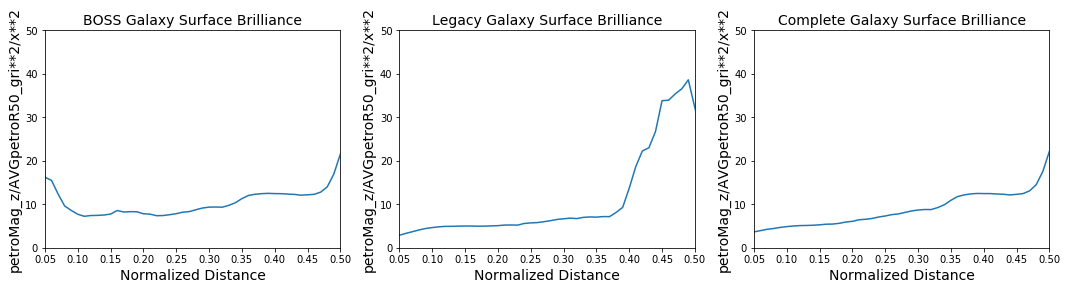

In [6]:
def f(x,y,z):
    return y/z**2

fontsize=14
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.subplots_adjust(hspace=.4)

df=df_boss
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.AVGpetroR50_gri)]
df = HULib.fix_BOSS_data(df)

df0=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df0.plot(x="alpha",y="Me", ax=axes[0], legend=False)
axes[0].set_xlim(0.05,0.5)
axes[0].set_ylim(0.0,50)
axes[0].set_title("BOSS Galaxy Surface Brilliance", fontsize=fontsize)
axes[0].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[0].set_ylabel("petroMag_z/AVGpetroR50_gri**2/x**2", fontsize=fontsize)
#########################################
#########################################
#########################################
#########################################
df=df_legacy
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.AVGpetroR50_gri)]
df = HULib.fix_BOSS_data(df)


df1=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df1.plot(x="alpha",y="Me", ax=axes[1], legend=False)
axes[1].set_xlim(0.05,0.5)
axes[1].set_ylim(0.0,50)
axes[1].set_title("Legacy Galaxy Surface Brilliance", fontsize=fontsize)
axes[1].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[1].set_ylabel("petroMag_z/AVGpetroR50_gri**2/x**2", fontsize=fontsize)

#########################################
#########################################
#########################################
#########################################

df_complete=pd.concat([df_boss,df_legacy])
df=df_complete
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.AVGpetroR50_gri)]
df = HULib.fix_BOSS_data(df)



df2=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df2.plot(x="alpha",y="Me", ax=axes[2], legend=False)
axes[2].set_xlim(0.05,0.5)
axes[2].set_ylim(0.0,50)
axes[2].set_title("Complete Galaxy Surface Brilliance", fontsize=fontsize)
axes[2].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[2].set_ylabel("petroMag_z/AVGpetroR50_gri**2/x**2", fontsize=fontsize)
fig = plt.gcf()
# fig.savefig(parameters.imgAddress + 'BrillianceWithoutEnergyCorrectionGRI.png', dpi=300)

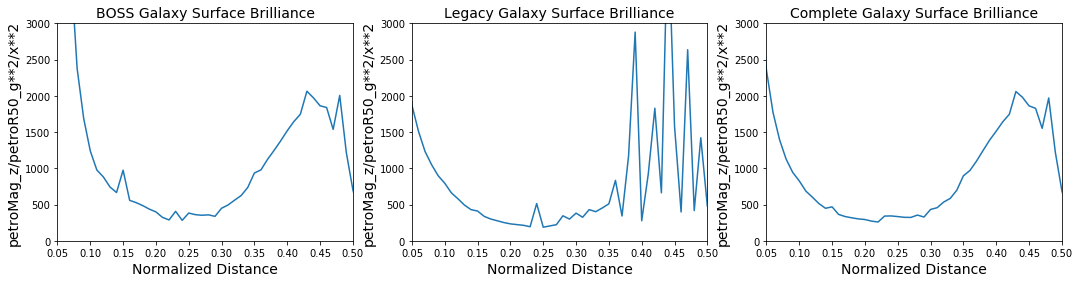

In [9]:
def f(x,y,z):
    return y/z**2/x**2/(1-x)

fontsize=14
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.subplots_adjust(hspace=.4)

df=df_boss
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_g)]
df = HULib.fix_BOSS_data(df)


df0=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df0.plot(x="alpha",y="Me", ax=axes[0], legend=False)
axes[0].set_xlim(0.05,0.5)
axes[0].set_ylim(0.0,3000)
axes[0].set_title("BOSS Galaxy Surface Brilliance", fontsize=fontsize)
axes[0].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[0].set_ylabel("petroMag_z/petroR50_g**2/x**2", fontsize=fontsize)
#########################################
#########################################
#########################################
#########################################
df=df_legacy
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_g)]
df = HULib.fix_BOSS_data(df)


df1=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df1.plot(x="alpha",y="Me", ax=axes[1], legend=False)
axes[1].set_xlim(0.05,0.5)
axes[1].set_ylim(0.0,3000)
axes[1].set_title("Legacy Galaxy Surface Brilliance", fontsize=fontsize)
axes[1].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[1].set_ylabel("petroMag_z/petroR50_g**2/x**2", fontsize=fontsize)

#########################################
#########################################
#########################################
#########################################

df_complete=pd.concat([df_boss,df_legacy])
df=df_complete
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_g)]
df = HULib.fix_BOSS_data(df)


df2=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df2.plot(x="alpha",y="Me", ax=axes[2], legend=False)
axes[2].set_xlim(0.05,0.5)
axes[2].set_ylim(0.0,3000)
axes[2].set_title("Complete Galaxy Surface Brilliance", fontsize=fontsize)
axes[2].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[2].set_ylabel("petroMag_z/petroR50_g**2/x**2", fontsize=fontsize)
fig = plt.gcf()
fig.savefig(parameters.imgAddress + 'BrillianceWithoutEnergyCorrectionGreen.png', dpi=300)

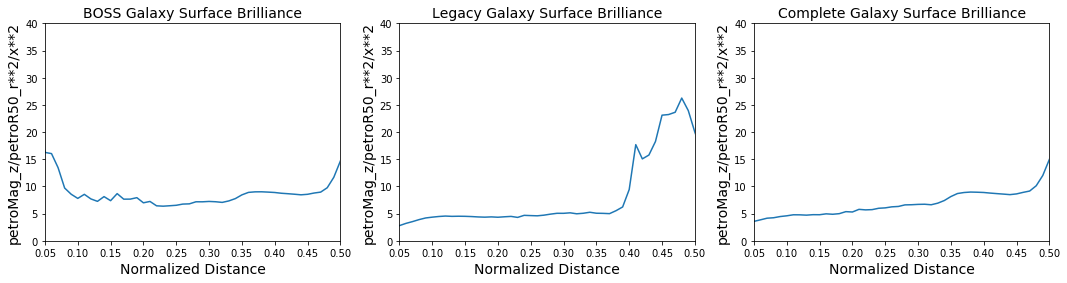

In [5]:
def f(x,y,z):
    return y/z**2*(1-x)

fontsize=14
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.subplots_adjust(hspace=.4)

df=df_boss
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_r)]
df = HULib.fix_BOSS_data(df)


df0=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df0.plot(x="alpha",y="Me", ax=axes[0], legend=False)
axes[0].set_xlim(0.05,0.5)
axes[0].set_ylim(0.0,40)
axes[0].set_title("BOSS Galaxy Surface Brilliance", fontsize=fontsize)
axes[0].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[0].set_ylabel("petroMag_z/petroR50_r**2/x**2", fontsize=fontsize)
#########################################
#########################################
#########################################
#########################################
df=df_legacy
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_r)]
df = HULib.fix_BOSS_data(df)


df1=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df1.plot(x="alpha",y="Me", ax=axes[1], legend=False)
axes[1].set_xlim(0.05,0.5)
axes[1].set_ylim(0.0,40)
axes[1].set_title("Legacy Galaxy Surface Brilliance", fontsize=fontsize)
axes[1].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[1].set_ylabel("petroMag_z/petroR50_r**2/x**2", fontsize=fontsize)

#########################################
#########################################
#########################################
#########################################

df_complete=pd.concat([df_boss,df_legacy])
df=df_complete
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_r)]
df = HULib.fix_BOSS_data(df)


df2=pd.DataFrame({'Me' : df.groupby( ['alpha'])['Me'].mean()}).reset_index()
df2.plot(x="alpha",y="Me", ax=axes[2], legend=False)
axes[2].set_xlim(0.05,0.5)
axes[2].set_ylim(0.0,40)
axes[2].set_title("Complete Galaxy Surface Brilliance", fontsize=fontsize)
axes[2].set_xlabel("Normalized Distance", fontsize=fontsize)
axes[2].set_ylabel("petroMag_z/petroR50_r**2/x**2", fontsize=fontsize)
fig = plt.gcf()
fig.savefig(parameters.imgAddress + 'BrillianceWithoutEnergyCorrectionRed.png', dpi=300)

In [7]:
def f(x,y,z):
    return y/z**2*(1-x)
df=pd.concat([df_boss,df_legacy])
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_g)]
df = HULib.fix_BOSS_data(df)
df0=pd.DataFrame({'Me' : df.groupby( [ 'x','y','z'])['Me'].sum()}).reset_index()

glue.qglue (star=df0)

AttributeError: 'NoneType' object has no attribute 'show'

(0, 1000000.0)

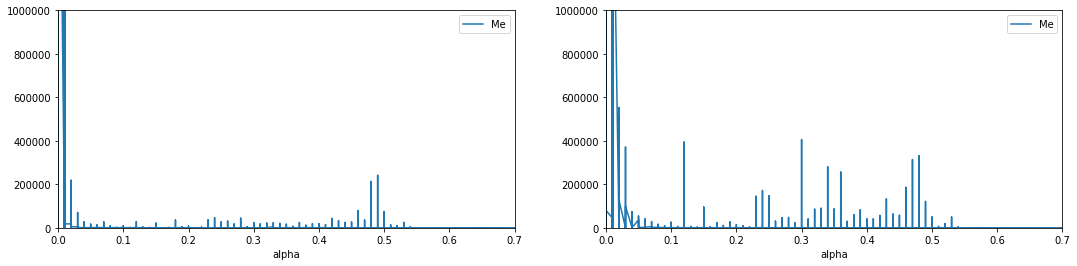

In [2]:
fontsize=14
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
fig.subplots_adjust(hspace=.4)

def f(x,y,z):
    return y/z**2/x**2
df=pd.concat([df_boss,df_legacy])
df['alpha']=[HULib.alphaZ(x) for x in df.Z]
df['NZ']=[ f(x,y,z) for (x,y,z) in zip(df.alpha, df.petroMag_z,df.petroR50_g)]
df = HULib.fix_BOSS_data(df)



df0=pd.DataFrame({'Me' : df.groupby( [ 'alpha','DEC'])['Me'].mean()}).reset_index()
df0.plot(x="alpha", y="Me",ax=axes[0])
axes[0].set_ylim(0,1E6)
df1=pd.DataFrame({'Me' : df.groupby( [ 'alpha','RA'])['Me'].mean()}).reset_index()
df1.plot(x="alpha", y="Me",ax=axes[1])
axes[1].set_ylim(0,1E6)

# 21023420 clinica angiocorpora lisaura
